In [4]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# Data Science in 30 minutes: Neural networks and `word2vec`

A _neural network_ is a method of machine learning which chains together a number of more basic models (_nodes_) at a number of _layers_, with each layer feeding into the next. To make this more clear, let's look at the most basic (1-node, 1-layer) neural network, the "perceptron".

## Neural Net Basics: The perceptron
The _perceptron_ is a linear decision boundary classifier\* that trains by an iterative learning approach.

The model works as follows:

- **Input**: A data point. This point is transformed into an $n$-length "feature vector" $\vec{v}$ $\in R^n$, with each element describing the value of that particular feature.
- **Output**: A classification, either -1 or 1.

Here's an example of some randomly-generated data. In the below scatterplot, we've created some random data points in a 2-dimensional vector space and classified them relative to the line $y = x$ (points "above" are class 0, points "below" are class 1). 

\*In fact, one can use [kernel methods](https://en.wikipedia.org/wiki/Kernel_perceptron) (much like with SVMs) to attempt nonlinear classification with perceptrons.

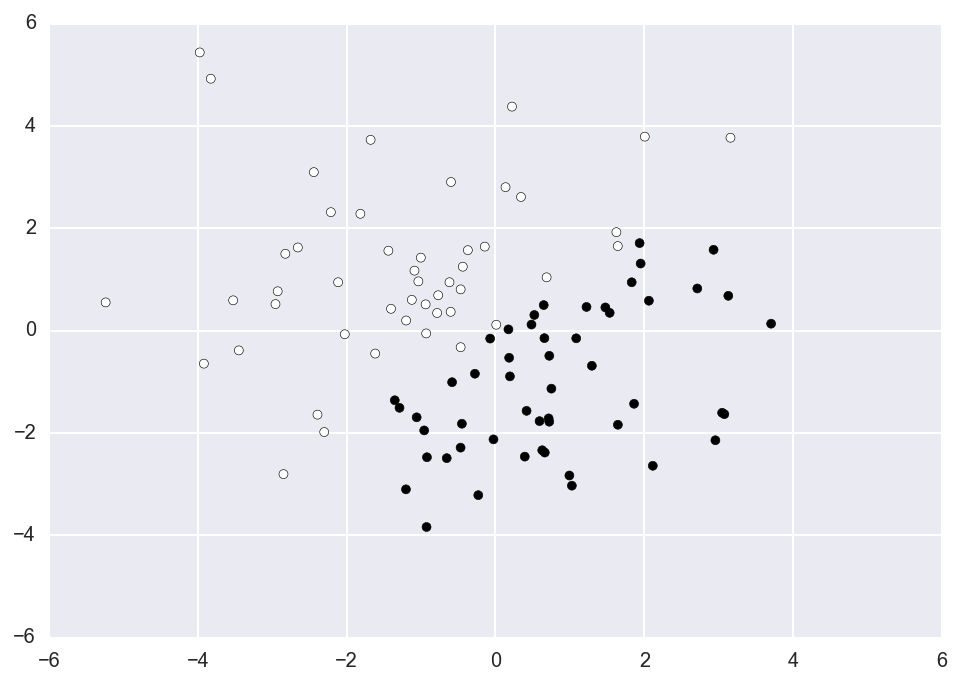

In [3]:
from sklearn import metrics
from numpy import random
import numpy as np
import matplotlib.pylab as plt
from scipy.special import expit as sigmoid

random.seed(42)
training_x  = np.array(zip(2*random.randn(100), 2*random.randn(100)))
training_t = [0 if x[1]  > x[0] else 1 for x in training_x]
training_data = zip(training_x, training_t)
plt.scatter([x[0] for x in training_x], [x[1] for x in training_x],  c=training_t)

What we're looking for is a model which correctly labels each of these points. Because the perceptron is linear, we can essentially think of the model as trying to draw the best possible line between the two classes of data points.

As mentioned above, the basic perceptron is linear, which means we can represent our model as another $n$-length "weight vector" $\vec{\mathbf{w}}$ - in the image below with input vector $\vec{v}$, we
 - compute the inner product $\vec{\mathbf{w}} \cdot \vec{v} := u$
 - calculate $f(u)$, where $f$ is an _activation function_ (in a perceptron, the Heaviside step function, as in the diagram below) and use this as our output predicted class.
 
Activation functions typically map some high-magnitude value into \[-1, 1\] - the Heaviside step function does this discretely based on sign. Another commonly used function, the _[logistic sigmoid function](https://en.wikipedia.org/wiki/Logistic_function)_, maps into the continuous intervial (0, 1). 

It may also be instructive to think of this as matrix multiplication (with $\vec{v}$ a $1 \times n$ matrix and $\vec{\mathbf{w}}$ an $n \times 1$ matrix)- when we chain together perceptrons for a neural net, we can in fact represent each layer of the model as a matrix.

![Perceptron](http://i.stack.imgur.com/KUvpQ.png)

### Training: 

#### In theory
Mathematically, whenever we perform supervised learning, we seek to minimize an _objective function_ which essentially measures how closely our model describes the training data. This objective function's input is our model's weights, which control exactly what the model is fitting to. In the case of the perceptron, those weights are our vector $\vec{\mathbf{w}}$.

While the standard perceptron's training algorithm provably converges on linearly separable data, our function is not smooth (due to the use of the Heaviside function), and the proof is not immediate from standard convex optimization methods.

Let's look at a slightly modified perceptron using the [logistic sigmoid function](http://mathworld.wolfram.com/SigmoidFunction.html) $\sigma$ as the activation function instead of the Heaviside function, and derive our training method from there.

Here's our objective function: 

$$ E(\vec{\mathbf{w}}) = \sum_{i=1}^{|T|} \frac{1}{2} (t_i - f(u_i)) ^2 $$

Where we take training samples from our training set $T$. We let $t_i$ be our gold standard datum for the $i$-th training sample, and let $x_i$ be the $i$-th sample's input. Then, $ u_i = u(\vec{x}_i) = \vec{\mathbf{w}} \cdot \vec{x}_i$, and $f(u_i) = \sigma (u_i)$ is the output given by our model with the current weights on this training sample. In otherwords, instead of the Heaviside function as our activation function $f$, we've switched to the logistic sigmoid. For simpler derivation later, let $f_i = f(u_i)$.

As it turns out, this is the objective function for a very familiar model - [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). We can use the usual convex optimization methods - namely [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) - to train our model.

To see this, let's take $\frac{\partial{E}}{\partial{w_j}}$, the derivative of the objective with respect to the $j$-th index of the weight vector $\vec{\mathbf{w}}$. Noting that differentiation is linear and using the chain rule, it's easy to see that:

$$ \frac{\partial{E}}{\partial{w_j}} = 
        \sum_{i} \frac{\partial{E}}{\partial{f_i}} \cdot \frac{\partial{f_i}}{\partial{u_i}} \cdot \frac{\partial{u_i}}{\partial{w_j}} $$
        
Here's each of those terms, from the equation above (and noting $\frac{d\sigma}{dx} = \sigma(x) ( 1 - \sigma(x))$:

$$ \frac{\partial{E}}{\partial{f_i}} = (t_i - f_i) \\
   \frac{\partial{f_i}}{\partial{u_i}} =  (f_i)(1-f_i) \\
   \frac{\partial{u_i}}{\partial{w_j}} = x_i
$$
Because we're using SGD, we don't need to take the gradient with respect to the entire function - just the single example $x_i$ we plan to iteratively update $\vec{\mathbf{w}}$ with.

Hence at each update phase, we update our weights in the direction of the local gradient as follows:

$$ \vec{\mathbf{w_0}} = [0 ..... 0]\\
\vec{\mathbf{w_{i+1}}} = \vec{\mathbf{w_i}} - \eta  \cdot (t_i - f_i)(f_i)(1 - f_i) \vec{x}
$$

Where $\eta$ is the _learning rate_, a parameter we choose (typically small, maybe .1 or .01) that determines the rate at which our weight vector updates after seeing each training example.

#### In practice
Let's show a low-dimensional example of the algorithm we just derived. We train the sigmoid perceptron by iterating over all the data multiple times, and updating our weight vector $\vec{\mathbf{w}}$ as we see each data point. We call 1 full iteration over the training set an _epoch_.

In [5]:
epochs = 3000
weights = np.array([.15, .15])
learning_rate = .001
for epoch in xrange(epochs):
    for x_vector, t in training_data:
        pred = sig(np.inner(x_vector, weights))
        update = learning_rate * pred * (1 - pred) * (pred - t)
        weights = weights - (update * x_vector)
    if epoch > 0 and epoch % 1000 == 0:
        print "weights after epoch %s : %s" % (str(epoch), str(weights))
        
        
actuals = [t[1] for t in training_data]
preds = [1 if sigmoid(np.inner(t[0], weights)) > .5 else 0 for t in training_data]

print "Mean Absolute Error:", metrics.mean_absolute_error(actuals, preds)
print "Mean Squared Error:", metrics.mean_squared_error(actuals, preds)
print "R^2:", metrics.r2_score(actuals, preds)


NameError: name 'sig' is not defined

Exactly what we'd expect - a perfect fit! Now let's plot the separating hyperplane the model developed:

In [ ]:
#We rotate the resultant vector 90 degrees. 
m = -(weights[0])/(weights[1])
#Since we didn't include a bias term, we start at (0,0)
p1 = [0, 0]
x2 = 1.3
y2 = (x2 - p1[0])*m + p1[1]
p2 = [x2, y2]

def drawLine2P(x,y,xlims):
    xrange = np.arange(xlims[0],xlims[1],0.1)
    A = np.vstack([x, np.ones(len(x))]).T
    k, b = np.linalg.lstsq(A, y)[0]
    plt.plot(xrange, k*xrange + b, 'k')

plt.scatter([x[0] for x in training_x], [x[1] for x in training_x],  c=training_t)
drawLine2P([p1[0], p2[0]], [p1[1], p2[1]], [-6, 6])


### Pitfalls:
The perceptron is too simple of a model for more complex classification tasks. However, chaining perceptrons into a neural network allows for surprisingly good results across a wide variety of problems.

## Chaining Perceptrons into Neural Networks

In the below diagram (a visual representation of a neural net), you can think of each "hidden node" as a perceptron that takes the average of the input layers' values as input and produces a unique prediction of its own:
![A Neural Network](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)

That said, there are a couple of important differences, mathematically speaking:

1. As mentioned above, perceptrons typically use the Heaviside step function for activation. In neural nets, the logistic sigmoid function is typical. 
2. We derived the single node sigmoid training algorithm above - the SGD-based method we use to train a multi-layer neural network is commonly known as _backpropogation_.

## word2vec
As it turns out, the skip-gram and continuous-bag-of-words neural networks used in [word2vec](https://code.google.com/p/word2vec/) are simple neural networks that produce a suprisingly cool result on natural language data. 

word2vec is a library that, given a corpus of natural language text data (think Wikipedia articles), maps each word into a high-dimensional vector space. For those of you familiar with information retrieval theory, the concept is widely used in that field: a word's position in the vector space denotes how _similar_ it is to other nearby words. 

In this way we can create interesting clusters of related words, and, somewhat more compellingly, learn nontrivial associations between words.

For example, consider the analogy, 

"Man is to King as Woman is to \_\_\_\_\_\_\_"

As an English speaker, you know the answer is "Queen". As it turns out, a well-trained word2vec vector space can also come to this conclusion by the following vector computation:

` closest( (vector("king") - vector("man")) + vector("woman") )`

Where we measure closeness via cosine similarity. Let's take a look at a pre-trained `word2vec` model.

## The tool: `gensim`
Gensim is a great python library for various topic-modelling and clustering tasks. The library recently added word2vec to its toolbox - it's a thin wrapper around the highly optimized [C implementation](https://code.google.com/p/word2vec/). 

To install gensim, you can simply run `conda install gensim` (if you're still on `pip` you can use this as well). You'll need:

- at least `numpy/scipy` installed
- ideally a C compiler so that you can use optimized word2vec training (as noted [here](https://radimrehurek.com/gensim/models/word2vec.html)).

We'll also use the first [Pre-trained model](https://code.google.com/p/word2vec/#Pre-trained_word_and_phrase_vectors) (from the Google News Dataset), from the `word2vec` Google Code page above, to illustrate some of the classic analogies we mentioned above. Note these vectors are 1.5GB, so sit back and relax! 

##  The code - pre-trained model.

First, let's look at the pre-trained model and see what fun analogies we can come up with.


In [ ]:
import gensim
googlenews_model = gensim.models.word2vec.Word2Vec.load_word2vec_format("GoogleNews-vectors-negative300.bin",
                                                                        binary=True)

In [ ]:
googlenews_model.most_similar("king")

If asked to write down some words associated with royalty, you or I would probably write down similar lists. 

Clustering, however, is a long-solved problem - [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), for example, could produce similar lists for us if trained on this dataset. What's particularly interesting about `word2vec` is the following sort of computation:

$$ vec(king) - vec(man) + vec(woman) $$

When we perform this vector operation, what words are closest to the resultant vector? Are they meaningful? Let's try! 

We'll start with the example we used above:

In [ ]:
# vec(king) - vec(man) + vec(woman)
googlenews_model.most_similar(positive=["king", "woman"], negative=["man"])

Note above that "monarch", a gender-neutral term, is also listed as quite similar. Does this hold when we subtract `vec(man)` without adding in `vec(woman)`?

In [ ]:
googlenews_model.most_similar(positive=["king"], negative=["man"])

Not quite - though "kingdom" is another interesting similarity when we think of "man" as referring to a human.

### The layers
As is typical of simple neural nets, CBOW has an _input_ layer, a _hidden_ layer, and an _output_ layer. A linear transformation (ie a matrix) governs the movement from input to hidden, and another handles movement from hidden to output - the above diagram labels these transformations $\mathbf{W}$ and $\mathbf{W'}$. In CBOW, we have

- **input**: Four _one-hot encoded_\* words - i.e. $1 x V$ vectors where $V$ is the size of our vocabulary, all values are 0 except for one.
- $\mathbf{W}$: A $V x N$ matrix that transitions into the hidden layer, and notably maps our encoded word into an $N$-dimensional (usually $N\approx300$) vector space. In otherwords, after we've completed training this model, we'll /only/ care about this matrix and the embedding it creates for our vocabulary.
- **hidden**: A $1 x N$ vector that represents the mapping of our input word into the desired vector space
- $\mathbf{W'}$: An $N x V$ matrix transitioning between the hidden layer and the output.
- **output**: A single one-hot encoded word - the model's prediction for most likely to occur given the surrounding four-word context.

\* This isn't strictly true as word2vec actually uses a different, optimized tree structure - but the one-hot encoding is illustrative.

Note that $\mathbf{W}$ is the artifact we're looking for, as it transitions our encoded words into an interesting vector space. Hence, to develop $\mathbf{W}$, we must simply train this model and recover the weight parameters.

## Let's try it!
We decided to try this on some real-world data, in particular Yelp's [Academic Dataset](https://www.yelp.com/academic_dataset), to see if we could come up with anything interesting.

Some questions we can ask via this analogy structure:

- What's the closest thing to Pizza in France? 
- What is non-spicy Mexican food?
- The tagine is emblematic of North African cuisine: is there anything similar in other geographies?

## The dataset: The Yelp Academic Datset 

We host a version of [Yelp's Academic Dataset](https://www.yelp.com/academic_dataset) for our fellows. 


To follow along, you should
- Install `gensim` as above.
- Download the Yelp review data for yourself.

First, we can query the Google News model as a baseline. In fact, if we wanted, we could build off of this model and simply continue training with the extra sentences provided by the Yelp Academic dataset.

In [ ]:
# vec('burrito') - vec('mexican') + vec('chinese')
googlenews_model.most_similar(positive=["burrito", "chinese"], negative=["mexican"])

And another fun one: let's see the "default" burrito is:

In [ ]:
# vec('burrito') - vec('mexican')
googlenews_model.most_similar(positive=["burrito"], negative=["mexican"])

## The Code: Training the model.
Now that we've looked at a well-trained model, let's try some modelling of our own!

Our text processing leaves something to be desired. However, one of the coolest things about `word2vec` is that even with the most trivial of input cleanings, we get interesting results, as you'll see below.

In [ ]:
#TODO: better text processing
import simplejson as json
reviews = []
lines = open("yelp_train_academic_dataset_review.json")
for line in lines:
    reviews.append(json.loads(line))
reviews = [r['text'].lower().split(" ") for r in reviews]

In [ ]:
# this took about an hour on our 16GB Digital Ocean instance - go grab lunch!
yelp_model = gensim.models.word2vec.Word2Vec(reviews)

You can configure logs to send output to a file if you like - the [gensim docs](https://radimrehurek.com/gensim/tutorial.html) explain how to activate logging if that's something that interests you. Here's what training output looks like when using Spark's word2vec implementation:

![Training output](progress.png)

wordCount is how many words we've seen, and alpha is the learning rate - a useful optimization for training neural nets is to incrementally decrease the learning rate as time goes on and we converge toward the objective function's minimum. On our local setup with gensim (using a [16gb DigitalOcean instance](https://www.digitalocean.com/pricing/)), training on this dataset takes about 30 minutes.

Once the model is trained, we can write it out to a file to load up later.

In [ ]:
yelp_model.save("yelp_word2vec.model")

## Querying a Trained Model

Once we have the model trained, we can begin to query the vector space for interesting results and similarities. `model.most_similar` lets us pass in a word to get the closest vectors to that word (if it exists in the dataset). Take a look below at some of the immediate results we found:

In [ ]:
import gensim
yelp_model = gensim.models.word2vec.Word2Vec.load("yelp_word2vec.model")

In [ ]:
yelp_model.most_similar("chinese")

In [ ]:
yelp_model.most_similar("mexican")

Again, the above is more or less what we'd expect from LDA on this dataset.

How does our model compare to Google News?

In [ ]:
yelp_model.most_similar(positive=["chinese", "burrito"], negative=["mexican"])

Not much here - vermicelli are noodles, beef/chicken might be getting to something - but this is an early hint that our dataset might not be big enough to effectively build an interesting vector space. And clearly we need to improve our text processing.

In [ ]:
yelp_model.most_similar("pizza")

Clearly, we have some tokenizing issues, but more or less what we'd expect. Maybe we can try looking for pizza styles/places to avoid?

In [ ]:
yelp_model.most_similar(positive=["pizza", "nyc", "bad"])

Note to self: Avoid Grimaldi's, and maybe Difara's! Maybe pizza in Brooklyn? (This is probably an artifact of the "nyc" vector's weight).

## The dataset itself and future exploration

This dataset itself has an issue we can't resolve with better parsing or parameter tweaking: it's too small to train a truly effective word2vec model. We got some fun and interesting results, but really, we'd want to run this on something closer to all of Yelp's restaurant review text to develop some really cool analogies. Of course, Yelp doesn't simply make all of its data available for free - however, Yelp is one of our hiring partners ;).

# References and useful links
  
http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf - a good explanation of word2vec including a succinct overview of backpropogation, as well as `wevi`, the tool we used to visualize the algorithm and its embedding